In [19]:
import torch
import torch.nn as nn
from torchsummary import summary
from model import Net
from dataset import DatasetLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

from torch.optim.lr_scheduler import StepLR
from func_train_test import train, test
from rf_calculator import summary_with_rf

get_data = DatasetLoader(batch_size=128)

train_loader = get_data.train_loader()
test_loader = get_data.test_loader()

# Analyze the first batch of 512 images
images, labels = next(iter(train_loader))
print(f'Shape of the batch - {images.shape}')
print(f'Total images in the batch - {len(labels)}')

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')






Files already downloaded and verified


/home/xpz1/tsai_work/ERAV4/S7_Assignment/transforms.py:51: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_height=4, min_width=4, fill_value=0, mask_fill_value=None, p=0.5),
/home/xpz1/tsai_work/ERAV4/S7_Assignment/transforms.py:51: UserWarning: Argument 'mask_fill_value' is not valid and will be ignored.
  A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_height=4, min_width=4, fill_value=0, mask_fill_value=None, p=0.5),


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Shape of the batch - torch.Size([128, 3, 32, 32])
Total images in the batch - 128


In [20]:
use_cuda = torch.cuda.is_available()
print(f"Cuda available ###### {use_cuda}")
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))
summary_with_rf(model, input_size=(3, 32, 32))

Cuda available ###### True
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 64, 32, 32]          18,432
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]             576
           Conv2d-11           [-1, 64, 32, 32]           4,096
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
       

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
criterion = F.nll_loss
#criterion = nn.CrossEntropyLoss()

# Use OneCycleLR scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    epochs=50,
    steps_per_epoch=len(train_loader)
)

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

EPOCHS = 35
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_loss_avg, train_acc_avg = train(model, device, train_loader, optimizer, criterion, scheduler, epoch)
    test_loss_avg, test_acc_avg, misclass_data = test(model, device, test_loader, criterion)
    train_losses.append(train_loss_avg)
    train_acc.append(train_acc_avg)
    test_losses.append(test_loss_avg)
    test_acc.append(test_acc_avg)
    lrs.append(scheduler.get_last_lr()[0])  # store last LR of this epoch


EPOCH: 0


Epoch=0 LR=0.00505 Avg Training loss=1.6228 Batch Loss=1.4684 Batch_id=390, Acc=39.89: 100%|██████████| 391/391 [00:06<00:00, 64.53it/s]



Test set: Average loss: 1.3418, Accuracy: 50.13%

EPOCH: 1


Epoch=1 LR=0.00815 Avg Training loss=1.2696 Batch Loss=1.2931 Batch_id=390, Acc=54.14: 100%|██████████| 391/391 [00:06<00:00, 64.89it/s]



Test set: Average loss: 1.1661, Accuracy: 58.72%

EPOCH: 2


Epoch=2 LR=0.01317 Avg Training loss=1.1202 Batch Loss=1.1070 Batch_id=390, Acc=59.84: 100%|██████████| 391/391 [00:06<00:00, 64.55it/s]



Test set: Average loss: 0.9963, Accuracy: 64.64%

EPOCH: 3


Epoch=3 LR=0.01989 Avg Training loss=1.0128 Batch Loss=0.9076 Batch_id=390, Acc=63.86: 100%|██████████| 391/391 [00:06<00:00, 64.65it/s]



Test set: Average loss: 0.9007, Accuracy: 67.95%

EPOCH: 4


Epoch=4 LR=0.02468 Avg Training loss=0.9506 Batch Loss=0.9023 Batch_id=237, Acc=66.15:  61%|██████    | 238/391 [00:03<00:02, 62.97it/s]


KeyboardInterrupt: 

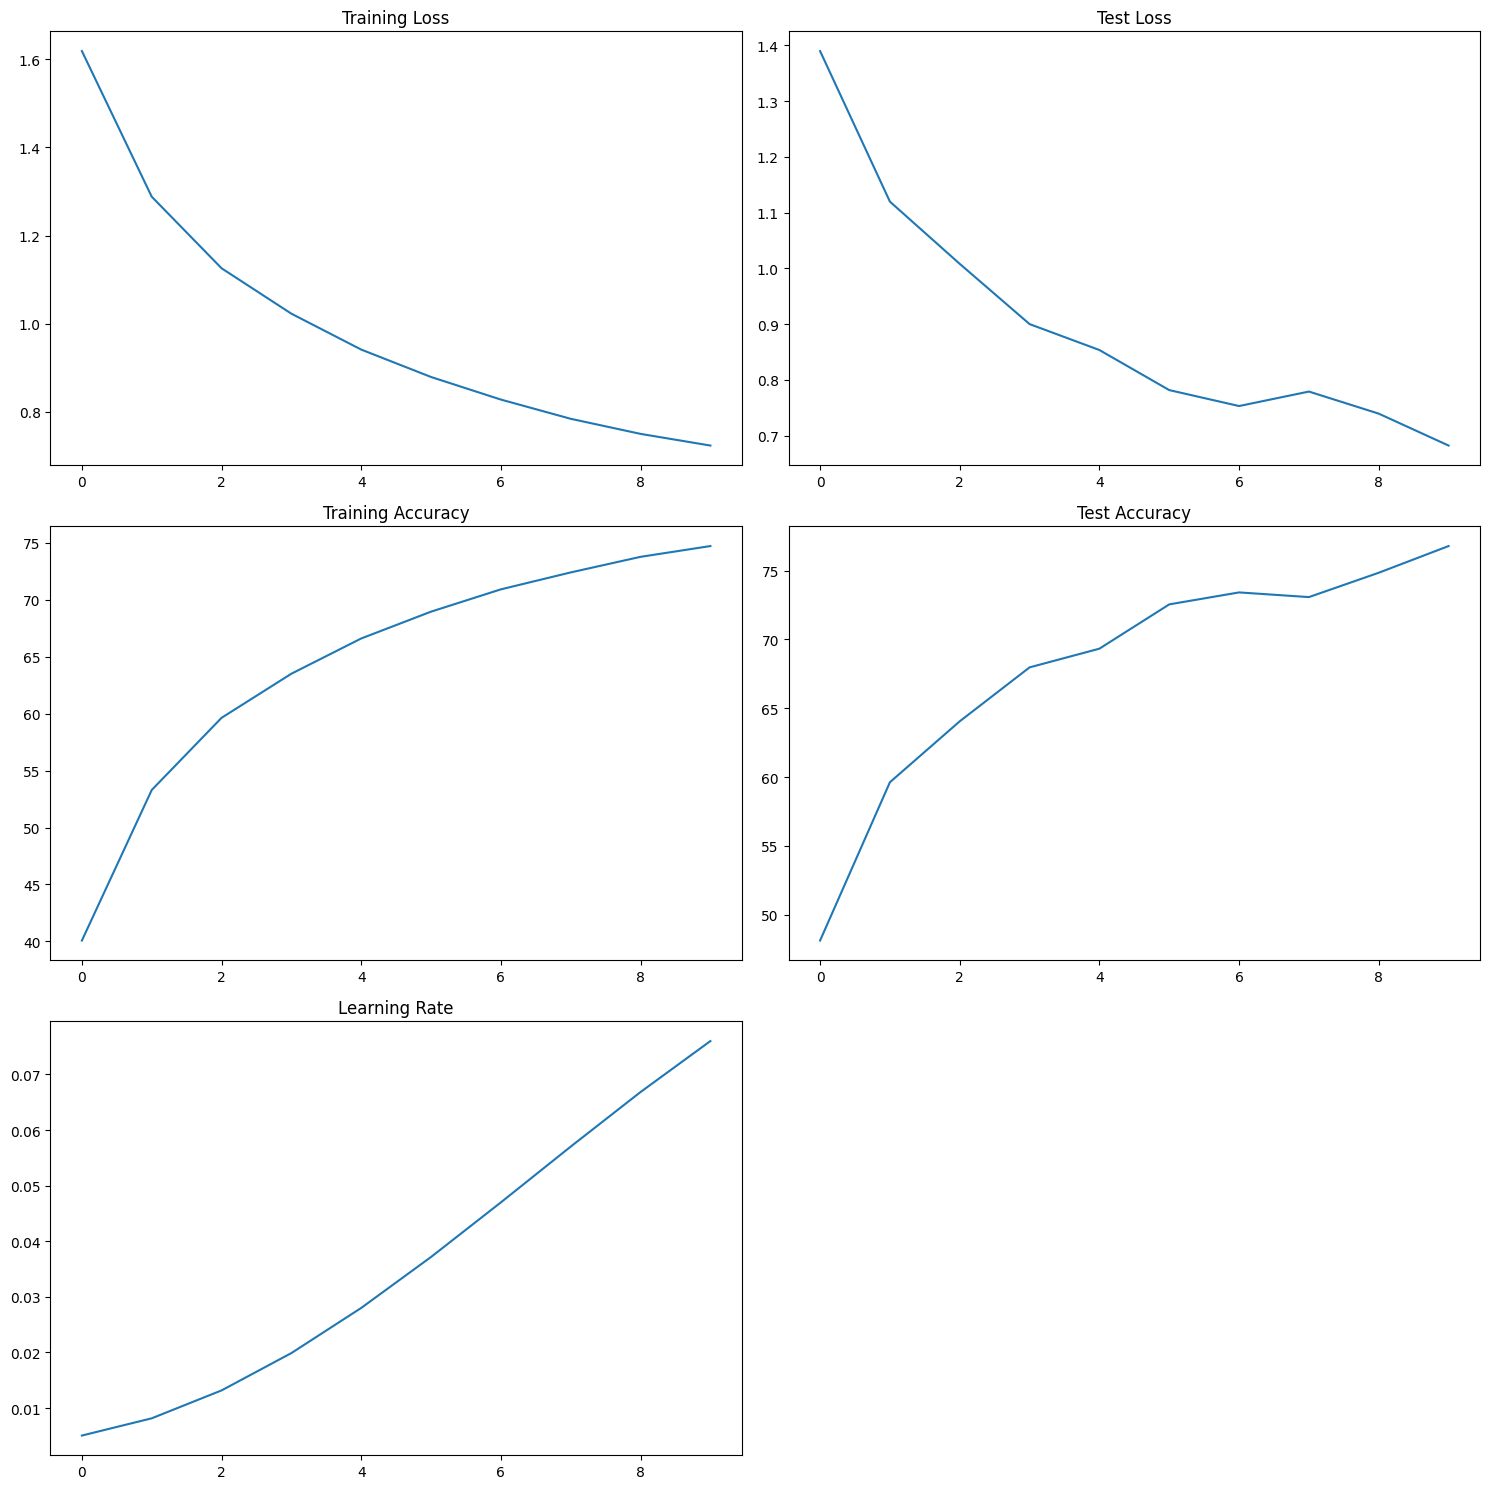

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15,15))

# Training Loss
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

# Training Accuracy
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

# Test Loss
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

# Test Accuracy
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Learning Rate
axs[2, 0].plot(lrs)
axs[2, 0].set_title("Learning Rate")

# Hide empty subplot if unused
axs[2, 1].axis("off")

plt.tight_layout()
plt.show()